Importing all required packages

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

Importing the CSV file

In [230]:
filtered_cardiac_interventions = pd.read_csv('filtered_cardiac_interventions.csv')
filtered_cardiac_interventions.head(5)

,Mission ID,Service Name,Latitude Permanence,Longitude Permanence,Latitude Intervention,Longitude Intervention,Vector Type,T0,T1,T2,T3,T4,T5,T6,Abandon Reason,Original File,T3_T0_difference_minutes,Vector Type 2,Dead
0,10221520047,HA UR GEEL AZ St Dimpna,51.16013,4.99975,51.20685,5.13662,MUG,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46,NaN,NaN,2022-06-01 06:49:27,NaN,interventions_cardiac,18.883333,NaN,0
1,10221520095,BA ANTW [Kaai 606] SIHWA,51.31287,4.32425,51.24848,4.43869,AMB,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29,NaN,NaN,2022-06-01 09:59:48,Overleden,interventions_cardiac,4.233333,MUG,1
2,10221520224,HA UR ANTW Stuivenberg,51.22249,4.43629,51.28273,4.42134,MUG,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40,NaN,NaN,2022-06-01 15:43:14,Overleden,interventions_cardiac,13.416667,AMB,1
3,10221520316,FA HVP ANTW [Zuid] Antwerpen,51.20550,4.39722,51.17895,4.39024,AMB,2022-06-01 19:22:57,2022-06-01 19:24:31,2022-06-01 19:28:39,2022-06-01 19:33:54,2022-06-01 20:02:54,2022-06-01 20:12:05,2022-06-01 20:28:04,NaN,interventions_cardiac,10.950000,MUG,0
4,10221520324,HA UR HERA AZ,51.18513,4.83741,51.20520,4.76586,AMB,2022-06-01 19:45:13,2022-06-01 19:46:14,2022-06-01 19:50:10,2022-06-01 19:54:50,2022-06-01 20:54:40,NaN,NaN,Overleden,interventions_cardiac,9.616667,MUG,1


Logistic regression analysis, approach 1: Vector Type is also used as a (categorical) feature

In this case, 'Vector Type' is also taken into account and one-hot encoded

In [235]:
# One-hot encode the 'Vector Type' column
vector_type_encoded = pd.get_dummies(filtered_cardiac_interventions['Vector Type'], prefix='Vector_Type')

# Scale the numerical feature
scaler = StandardScaler()
scaled_numerical_feature = scaler.fit_transform(filtered_cardiac_interventions[['T3_T0_difference_minutes']])
scaled_numerical_feature_df = pd.DataFrame(scaled_numerical_feature, columns=['T3_T0_difference_minutes'])

# Reset indexes of both DataFrames to ensure they match
scaled_numerical_feature_df.reset_index(drop=True, inplace=True)
vector_type_encoded.reset_index(drop=True, inplace=True)

# Combine the scaled numerical feature with the one-hot encoded categorical features
X = pd.concat([scaled_numerical_feature_df, vector_type_encoded], axis=1)
y = filtered_cardiac_interventions['Dead']
X_unscaled = filtered_cardiac_interventions['T3_T0_difference_minutes']

# Training and test sets are split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y, test_size=0.2, random_state=42)

# Regression analysis is realized
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

# Cross-validation of the model performance
scores = cross_val_score(logreg, X_test, y_test, cv=10, scoring='accuracy')
print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean cross-validated accuracy: {scores.mean()}')

# Actual running of the model
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Feature names including the scaled numerical feature and the one-hot encoded features
feature_names = ['T3_T0_difference_minutes'] + vector_type_encoded.columns.tolist()

# Combine feature names with coefficients
coefficients = pd.DataFrame(logreg.coef_, columns=feature_names)

coefficients.head(5)

# Output the learned parameters
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)


Cross-validated accuracy scores: [0.50943396 0.54285714 0.56190476 0.53333333 0.6952381  0.56190476
 0.4952381  0.59047619 0.66666667 0.61904762]
Mean cross-validated accuracy: 0.5776100628930818
Coefficients: [[-0.00460194  0.17238997 -0.20220875  0.05138865]]
Intercept: [0.02200763]


Plotting the ROC Curve and estimating its accuracy

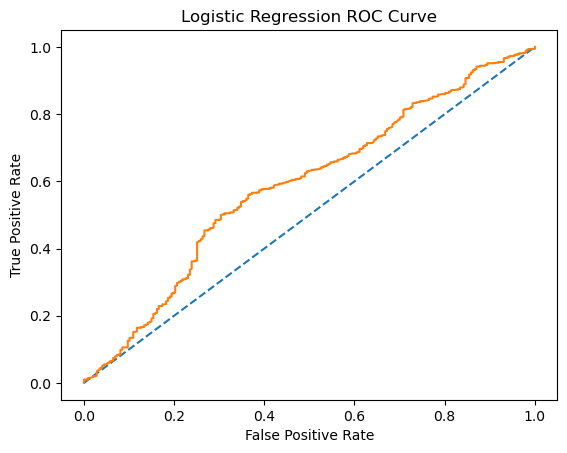

[0 0 1 ... 0 1 1]
0.5469332894742465
The AUC score is: 0.5870294277599856
95th percentile of intervention time for predicted survivors: 37.725
Average intervention time for predicted survivors: 16.743815331010452
95% confidence interval for the 95th percentile: [12.966250000000002, 14.083333333333334]


In [236]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

# Calculate the Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

# Evaluate the performance at the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
print(y_pred_optimal)

print(optimal_threshold)
print(f"The AUC score is: {roc_auc_score(y_test, y_pred_prob)}")

# Reset indexes of both DataFrames to ensure they match
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test_unscaled.reset_index(drop=True, inplace=True)

# Create a DataFrame for the test set including original inputs and predictions
test_df = pd.DataFrame({
    'Training/Test': ['Test'] * len(X_test),
    'Unscaled_T3_T0_difference_minutes': X_test_unscaled,
    'Scaled_T3_T0_difference_minutes': X_test['T3_T0_difference_minutes'],  # Showing the scaled 'T3_T0_difference_minutes' values
    'Vector_Type_AMB': X_test['Vector_Type_AMB'],
    'Vector_Type_PIT': X_test['Vector_Type_PIT'],
    'Vector_Type_MUG': X_test['Vector_Type_MUG'],
    'Y_True': y_test,
    'Y_Prob': y_pred_prob,
    'Y_Pred_Optimal': y_pred_optimal
})

#test_df.to_csv("C:/Users/MOGLIANA/github/MDA_project_team_Uganda/MDA_project_team_Uganda/ROC.csv", index=False)

# Filter for predicted survivors
predicted_survivors_df = test_df[test_df['Y_Pred_Optimal'] == 0]

# Extract the 'Original_T3_T0_difference_minutes' for predicted survivors
survivor_times = predicted_survivors_df['Unscaled_T3_T0_difference_minutes']

# Calculate the 95th percentile time
max_time_95_percentile = np.percentile(survivor_times, 95)
mean_time = np.mean(survivor_times)

# Bootstrap to find the 95% confidence interval of the 95th percentile
def bootstrap_ci(data, percentile, n_bootstraps=1000, ci=95):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True)
    stat = np.percentile(bootstraps, percentile, axis=1)
    lower_bound = np.percentile(stat, (100-ci)/2)
    upper_bound = np.percentile(stat, 100-(100-ci)/2)
    return lower_bound, upper_bound

ci_lower, ci_upper = bootstrap_ci(survivor_times, 50)

print(f"95th percentile of intervention time for predicted survivors: {max_time_95_percentile}")
print(f"Average intervention time for predicted survivors: {mean_time}")
print(f"95% confidence interval for the 95th percentile: [{ci_lower}, {ci_upper}]")

Logistic regression analysis, approach 2: Vector Type is used only to filter out and find the Tmax

In [233]:
# Filter for predicted survivors
filtered_cardiac_interventions_vectype = filtered_cardiac_interventions[filtered_cardiac_interventions['Vector Type'] == 'MUG']

# Scale the numerical feature
scaler = StandardScaler()
scaled_numerical_feature = scaler.fit_transform(filtered_cardiac_interventions_vectype[['T3_T0_difference_minutes']])
scaled_numerical_feature_df = pd.DataFrame(scaled_numerical_feature, columns=['T3_T0_difference_minutes'])

# Combine the scaled numerical feature with the one-hot encoded categorical features
X = scaled_numerical_feature_df
y = filtered_cardiac_interventions_vectype['Dead']
X_unscaled = filtered_cardiac_interventions_vectype['T3_T0_difference_minutes']

# Training and test sets are split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y, test_size=0.2, random_state=42)

# Regression analysis is realized
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

# Cross-validation of the model performance
scores = cross_val_score(logreg, X_test, y_test, cv=10, scoring='accuracy')
print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean cross-validated accuracy: {scores.mean()}')

# Actual running of the model
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Output the learned parameters
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)

Cross-validated accuracy scores: [0.56603774 0.62857143 0.57142857 0.59047619 0.66666667 0.61904762
 0.52380952 0.54285714 0.61904762 0.59047619]
Mean cross-validated accuracy: 0.5918418688230007
Coefficients: [[-0.02297224]]
Intercept: [0.0002156]


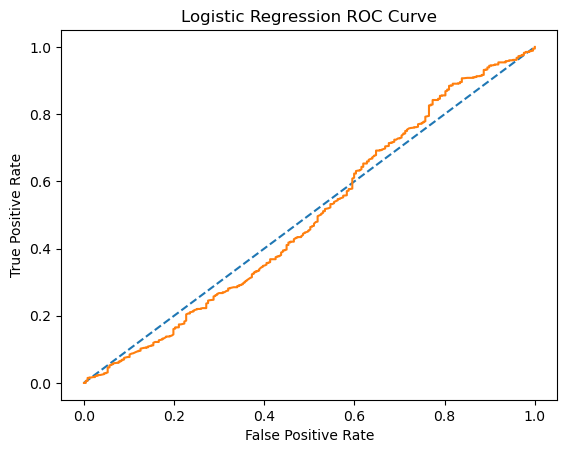

0.49671185426064596
The AUC score is: 0.4941436541986424
95th percentile of intervention time for predicted survivors: 61.440833333333224
Average intervention time for predicted survivors: 32.55761904761904
95% confidence interval for the 95th percentile: [48.09666666666659, 75.06666666666666]


In [234]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

# Calculate the Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

# Evaluate the performance at the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
print(optimal_threshold)
print(f"The AUC score is: {roc_auc_score(y_test, y_pred_prob)}")

# Reset indexes of both DataFrames to ensure they match
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test_unscaled.reset_index(drop=True, inplace=True)

# Create a DataFrame for the test set including original inputs and predictions
test_df = pd.DataFrame({
    'Training/Test': ['Test'] * len(X_test),
    'Unscaled_T3_T0_difference_minutes': X_test_unscaled,
    'Scaled_T3_T0_difference_minutes': X_test['T3_T0_difference_minutes'],  # Showing the scaled 'T3_T0_difference_minutes' values
    'Y_True': y_test,
    'Y_Prob': y_pred_prob,
    'Y_Pred_Optimal': y_pred_optimal
})

#test_df.to_csv("C:/Users/MOGLIANA/github/MDA_project_team_Uganda/MDA_project_team_Uganda/ROC.csv", index=False)

# Filter for predicted survivors
predicted_survivors_df = test_df[test_df['Y_Pred_Optimal'] == 0]

# Extract the 'Original_T3_T0_difference_minutes' for predicted survivors
survivor_times = predicted_survivors_df['Unscaled_T3_T0_difference_minutes']

# Calculate the 95th percentile time
max_time_95_percentile = np.percentile(survivor_times, 95)
mean_time = np.mean(survivor_times)

# Bootstrap to find the 95% confidence interval of the 95th percentile
def bootstrap_ci(data, percentile, n_bootstraps=1000, ci=95):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True)
    stat = np.percentile(bootstraps, percentile, axis=1)
    lower_bound = np.percentile(stat, (100-ci)/2)
    upper_bound = np.percentile(stat, 100-(100-ci)/2)
    return lower_bound, upper_bound

ci_lower, ci_upper = bootstrap_ci(survivor_times, 95)

print(f"95th percentile of intervention time for predicted survivors: {max_time_95_percentile}")
print(f"Average intervention time for predicted survivors: {mean_time}")
print(f"95% confidence interval for the 95th percentile: [{ci_lower}, {ci_upper}]")